In [1]:
import sys
import numpy as np

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmda/testing', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import pickle
from importlib import reload
import numpy as np

In [3]:
# Load state sequence and data from the pickle file
with open('/Users/david/Documents/mastersCode/ubm/final/tests/train-test-val.pkl', 'rb') as file:
    loaded_train_test_val = pickle.load(file)

# Access the loaded data
# loaded_ss = loaded_data['state_sequence']
# loaded_data = loaded_data['data']

In [4]:
from final.useful import *

In [5]:
nfft = 64 # 32
labels = np.unique(loaded_train_test_val['train'].sample_labels)
# get_log_power_feature()

In [6]:
train_labels = loaded_train_test_val['train'].sample_labels
train_samples = loaded_train_test_val['train'].samples
humpback_indices = train_labels == 0
train_samples_humpback = [item for item, condition in zip(train_samples, humpback_indices) if condition]


In [7]:
def get_feature(sample, nfft):
    feat = np.log(np.square(np.abs(librosa.stft(sample, n_fft=nfft)).T))
    return feat

In [8]:
train_features_humpback = []
for sample in train_samples_humpback:
    train_features_humpback.append(get_feature(sample, nfft))

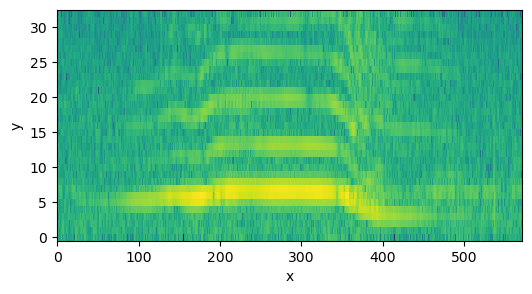

In [9]:
vis_helper(train_features_humpback[0])

In [10]:
# train_features_humpback_concat = np.concatenate(train_features_humpback)
smaller_features = train_features_humpback[0]

sbp_prior


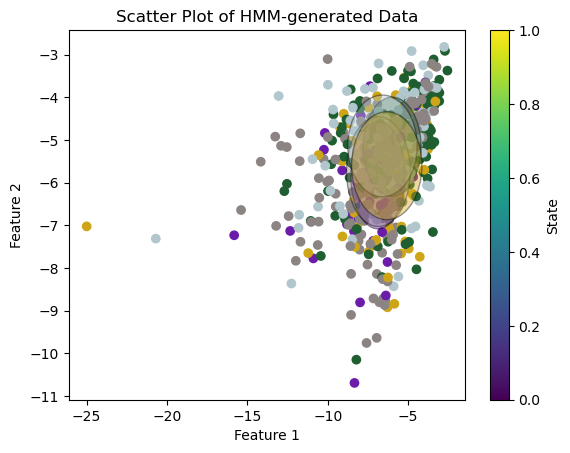

In [14]:
import final.models.hdphmm.hdphmmda.hdp_hmm_da as hdp_hmm_da
reload(hdp_hmm_da)
import final.models.hdphmm.hdphmmda.hdp_hmm_da_utils.utils as utils
reload(utils)
from final.models.hdphmm.hdphmmda.hdp_hmm_da_utils.hdp_hmm_da_consts import *
sbp = {
    ALPHA0: 0.2,
    GAMMA0: 0.2,
    KAPPA0: 0.2,
}
sbp[RHO0] = sbp[KAPPA0] / ( sbp[KAPPA0] + sbp[ALPHA0])
temp = 1

hdp_hmm = hdp_hmm_da.InfiniteDirectSamplerHMM(smaller_features, 5, Z_true=None, iterations=5, verbose=True, sbp=sbp, temp=1)

# plt.scatter(pca_features[:, 0], pca_features[:, 5], c=hdp_hmm.Z, cmap='viridis', marker='o')

In [12]:
hdp_hmm.fit()

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

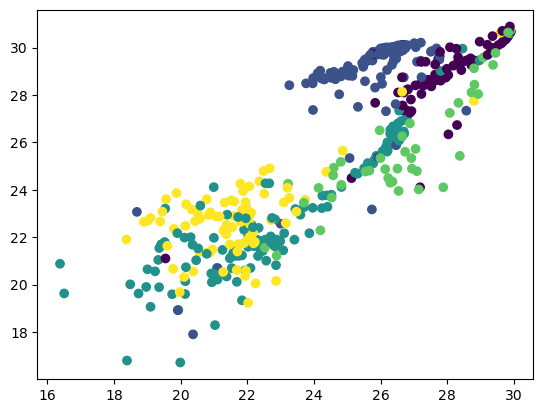

In [146]:
plt.scatter(mapped_array[:, 5], mapped_array[:, 6], c=hdp_hmm.Z, cmap='viridis', marker='o')

In [126]:
from hmmlearn.hmm import GaussianHMM
hmm_means = hdp_hmm.hmm.means_
hmm_covars = hdp_hmm.hmm.covars_

# try mapping back
means = []
covars = []
for i in range(hdp_hmm.K):
    means.append(pca_5.inverse_transform(hdp_hmm.hmm.means_[i]))
    covars.append(hdp_hmm.hmm.covars_[i])

covars_test = np.array([i for i in covars])
covars_test_v2 = np.array([np.diag(i) for i in covars])


hmm_i = GaussianHMM(hdp_hmm.K, covariance_type='diag')
hmm_i.n_features, hmm_means = smaller_features.shape[1], np.concatenate(means)
# hmm_i.covars_ = np.vstack(covars)

In [130]:
np.dot(pca_5.components_, np.dot(covars_test_v2[0], pca_5.components_))

array([2.24541391, 2.65601846, 1.65422213, 1.81971187, 1.94331858,
       2.37535776, 1.60999792, 2.25927668, 2.28601447, 1.888918  ,
       1.52411157, 1.72115898, 1.50788734, 1.80671606, 2.58782362,
       1.3171406 , 1.65281872, 1.49126728, 1.69183933, 1.56290197,
       1.2977204 , 1.41442094, 1.37875885, 1.38989056, 1.3144148 ,
       1.36947367, 1.31395203, 1.40463738, 1.33599614, 1.285872  ])

In [117]:
covar_hmm = np.vstack(covars)

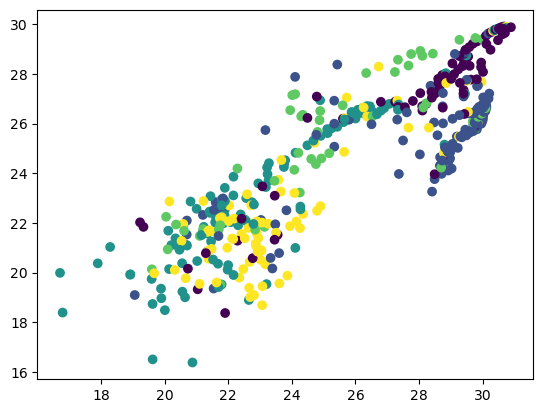

In [85]:
np.var(pca_features, axis=0)

array([78.65673   , 22.971115  , 16.841242  ,  7.000251  ,  6.164954  ,
        5.1818867 ,  3.9276185 ,  3.6531699 ,  3.312854  ,  2.7437928 ,
        2.5080554 ,  2.317854  ,  1.9362245 ,  1.8345454 ,  1.8214165 ,
        1.697447  ,  1.5738679 ,  1.385762  ,  1.2933296 ,  1.2719939 ,
        1.1631339 ,  1.1067381 ,  0.9723224 ,  0.914876  ,  0.87298703,
        0.8176243 ,  0.767053  ,  0.7599613 ,  0.66356236,  0.59779894],
      dtype=float32)